# Final Report: Diagnosing Heart Disease

## Introduction

Cardiovascular disease is the leading cause of death worldwide (1). During 2020, the United States saw 690,882 deaths from this condition, compared to the 345,323 deaths from COVID-19 (2). There are several risk factors for developing heart disease, and the consequences of heart disease vary in severity. The risk of death increases when other comorbidities are present, including COVID-19 (3). Because this disease affects a large amount of the population, it puts significant strain on the healthcare system.

We thus want to determine: Based on only two predictors gathered from health checkups performed by doctors, does somebody suffer from heart disease?

To answer this question, we analyze the Cleveland data file from (4), containing data collected by Robert Detrano at the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation in 1988. This dataset contains 303 instances. Besides recording basic information about the patient, this dataset includes multiple heart disease-related factors like blood pressure, blood sugar, heart rate, etc. 

## Methods & Results

To run this section, please make sure that you have at least R version 4.0.3 and that all libraries are installed and loaded correctly.

In [1]:
# load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 12, repr.plot.height = 7) 
# set seed to make sure our file is reproducible
set.seed(1020)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

As first step, the data is downloaded to get a first look at it:

In [2]:
# dowload the file
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod","cleveland.data")
# read the file. We do not have column names, so we set them manually
cleveland <- read_delim("cleveland.data", skip=20, col_names=FALSE, delim=" ")
colnames(cleveland) <- c('age','sex','chest_pain_type','resting_bp','cholesterol','high_blood_sugar','resting_ecg',
                        'max_heart_rate','exercise_pain','old_peak','slope','no_vessels_colored','thal','diagnosis','diagnosis_2')

# many of the column types do not work out as planned, so we set them explicitly.
cleveland <- mutate(cleveland,
                    sex=as.factor(str_trim(sex)),  # using str_trim to prevent weird whitespace issues
                    chest_pain_type=as.factor(str_trim(chest_pain_type)),
                    exercise_pain=as.factor(str_trim(exercise_pain)),
                    slope=as.factor(str_trim(slope)),
                    thal=as.factor(str_trim(thal)),
                    diagnosis=as.factor(str_trim(replace(diagnosis, str_trim(diagnosis)=="buff", "healthy"))), # we want to have "healthy" instead of "buff" as entry
                    diagnosis_2=as.factor(str_trim(diagnosis_2)),
                    high_blood_sugar=as.factor(str_trim(high_blood_sugar)),
                    resting_ecg=as.factor(str_trim(resting_ecg)),
                    # the doubles also need to be converted, they were listed as strings
                    resting_bp=as.numeric(resting_bp),
                    max_heart_rate=as.numeric(max_heart_rate),
                    old_peak=as.numeric(old_peak),
                    no_vessels_colored=as.numeric(no_vessels_colored))

cleveland

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_character(),
  X15 = col_character()
)

Warning message:
“Problem with `mutate()` input `no_vessels_colored`.
ℹ NAs introduced by coercion
ℹ Input `no_vessels_colored` is `as.numeric(no_vessels_colored)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_bp,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_pain,old_peak,slope,no_vessels_colored,thal,diagnosis,diagnosis_2
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy,H
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick,S2
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2,rev,sick,S1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3,norm,sick,S1
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1,norm,healthy,H
54,fem,notang,160,201,fal,norm,163,fal,0.0,up,1,norm,healthy,H


<span style="color: gray;">Table 1. Parsed Cleveland data set</span>

The column `diagnosis_2` in Table 1 distinguishes different kinds of sickness. However, we could not find any documentation about what these different classes actually mean, thus we will focus on the distinction between healthy and sick in the `diagnosis` column.

In [3]:
cleveland_select <- select(cleveland, -diagnosis_2)

cleveland_select

age,sex,chest_pain_type,resting_bp,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_pain,old_peak,slope,no_vessels_colored,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2,rev,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3,norm,sick
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1,norm,healthy
54,fem,notang,160,201,fal,norm,163,fal,0.0,up,1,norm,healthy


<span style="color: gray;">Table 2. Tidied Cleveland data set</span>

Having tidied the data, we now randomly split the data into a training and a testing set, taking 75% of the data for the training set.

In [4]:
split_data = initial_split(cleveland_select, prop=0.75, strata=diagnosis)
training_set <- training(split_data)
testing_set <- testing(split_data)

training_set

age,sex,chest_pain_type,resting_bp,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_pain,old_peak,slope,no_vessels_colored,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0,fix,healthy
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3,norm,sick
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2,rev,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,male,notang,124,255,true,norm,175,fal,0.0,up,2,norm,healthy
57,male,asympt,132,207,fal,norm,168,true,0.0,up,0,rev,healthy
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1,norm,healthy


<span style="color: gray;">Table 3. Cleveland training set</span>

We want to get a first impression of the different predictors in the data set, thus we compare the mean values of the numerical variables (Table 4) and the distribution of the factorial variables (Figure 1) for observations classified as sick and healthy.

In [5]:
summary_averages <- training_set %>%
    group_by(diagnosis) %>%
    summarize(count=n(), mean_age=mean(age), mean_resting_bp=mean(resting_bp), mean_cholesterol=mean(cholesterol),
              mean_max_heart_rate=mean(max_heart_rate), mean_old_peak=mean(old_peak),
              mean_no_vessels_colored=mean(no_vessels_colored, na.rm = TRUE))  # no_vessels_colored is the only column which had NA as mean

summary_averages

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,count,mean_age,mean_resting_bp,mean_cholesterol,mean_max_heart_rate,mean_old_peak,mean_no_vessels_colored
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
healthy,124,52.37903,128.4677,236.1452,157.2419,0.6330645,0.2416667
sick,104,56.44231,134.4423,248.3269,138.7885,1.5548077,1.1165049


<span style="color: gray;">Table 4. Average values of the numerical attributes</span>

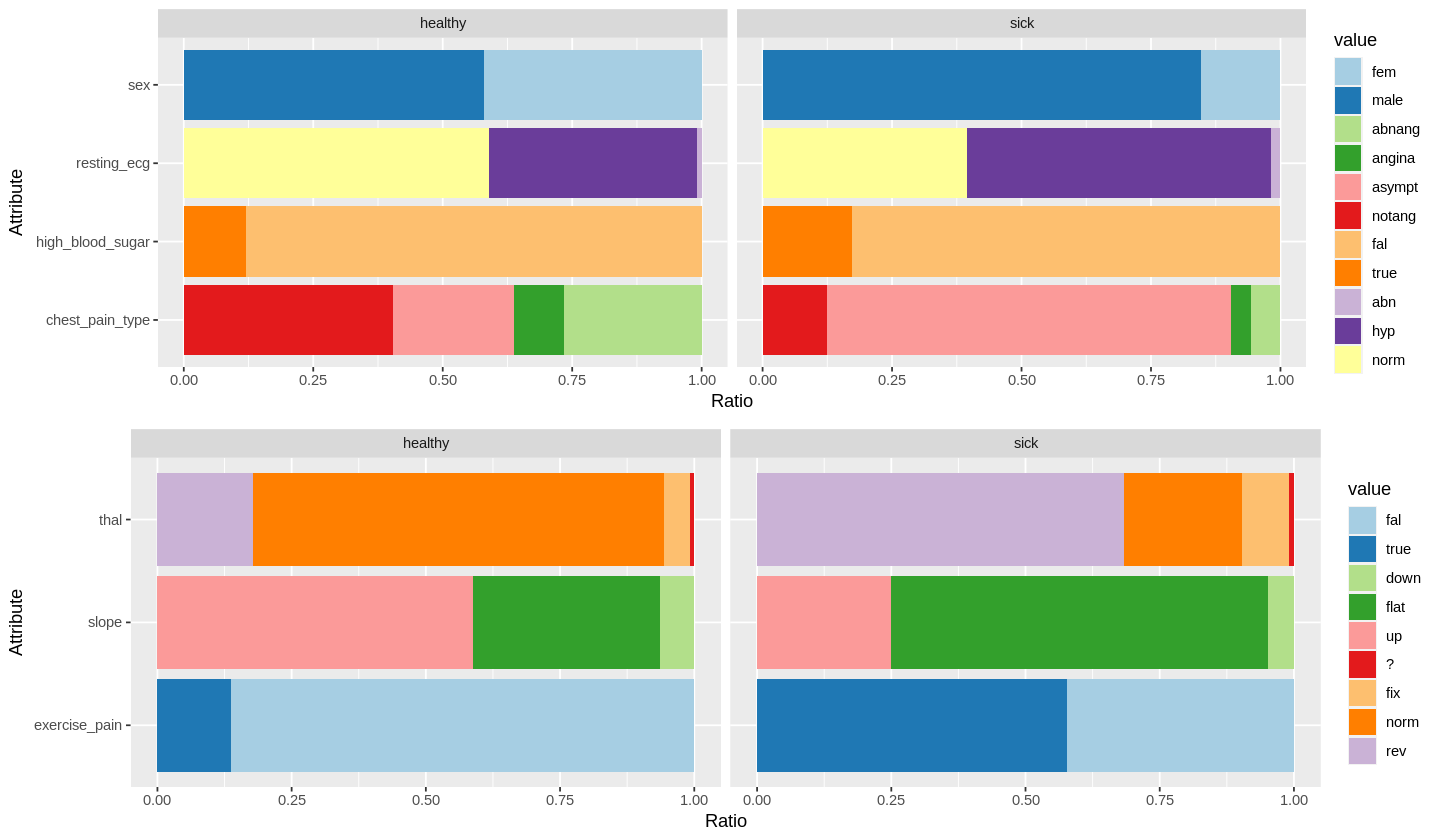

In [6]:
summary_factors <- training_set %>% 
    select(sex, chest_pain_type, high_blood_sugar, resting_ecg, diagnosis) %>% 
    pivot_longer(cols=sex:resting_ecg, names_to="attribute", values_to="value") %>% 
    ggplot(aes(y=attribute, fill=value)) + geom_bar(position="fill") + facet_grid(cols=vars(diagnosis)) +
        scale_fill_brewer(palette = "Paired") + labs(x="Ratio", y="Attribute", color="Value")

summary_factors_2 <- training_set %>% 
    select(exercise_pain, slope, thal, diagnosis) %>% 
    pivot_longer(cols=exercise_pain:thal, names_to="attribute", values_to="value") %>% 
    ggplot(aes(y=attribute, fill=value)) + geom_bar(position="fill") + facet_grid(cols=vars(diagnosis)) +
        scale_fill_brewer(palette = "Paired") + labs(x="Ratio", y="Attribute", color="Value")

plot_grid(summary_factors, summary_factors_2, ncol = 1)

<span style="color: gray;">Figure 1. The proportion of different values in each factorial attribute</span>

As the mean values do not tell us much about the numerical variables, we also plot their histograms to visualize the distribution of the variables (Figure 2). We will use this later to choose the predictors we want to use.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”


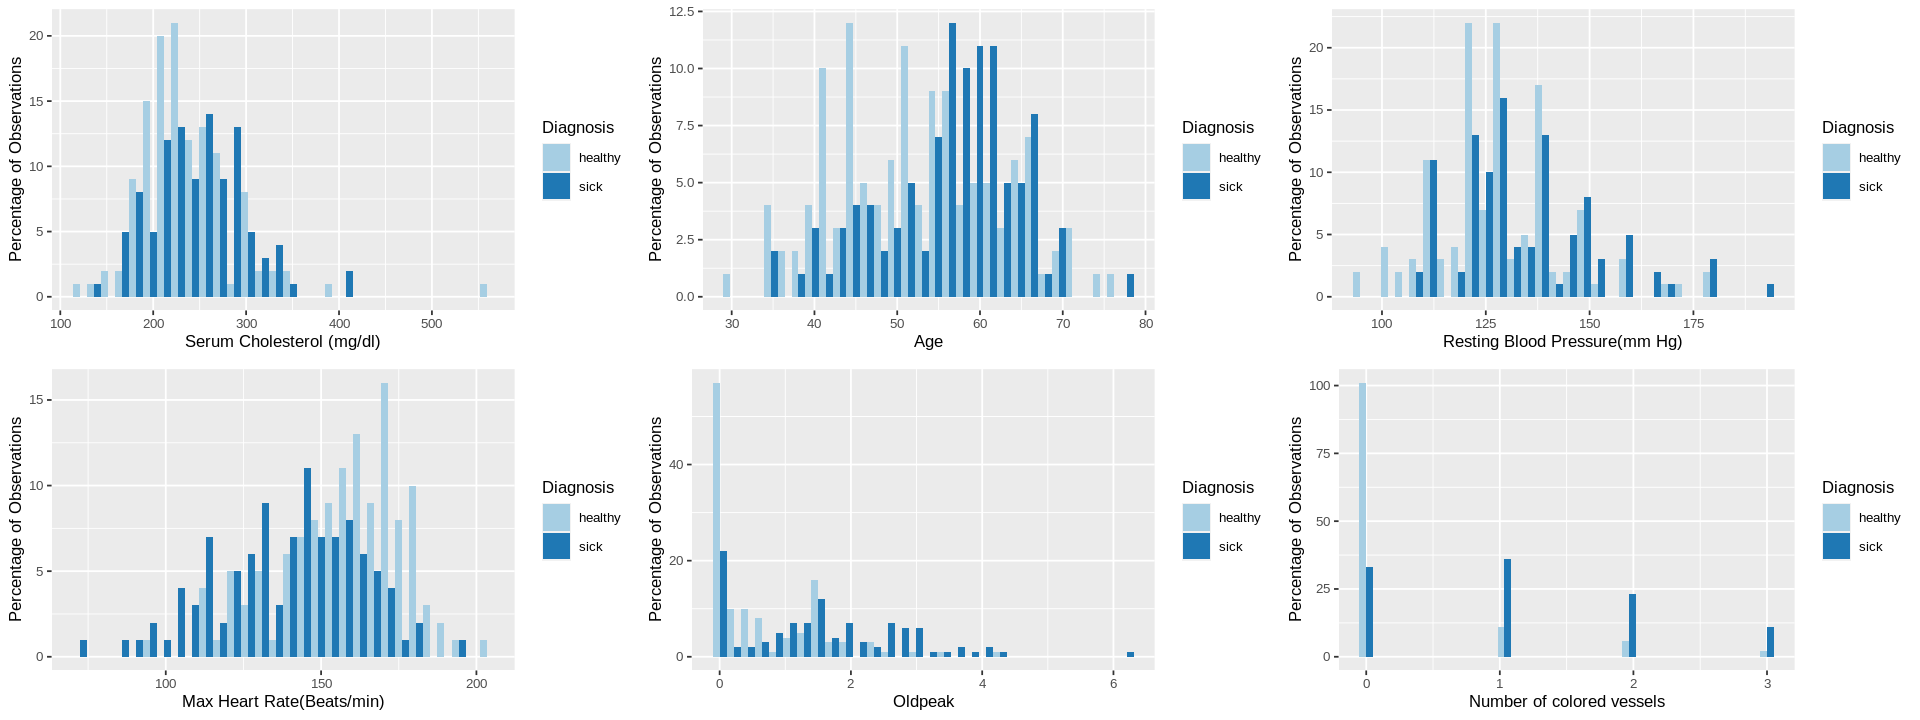

In [7]:
# Histograms for individual variables
cholesterol_histogram <- ggplot(training_set, aes(x = cholesterol, fill = diagnosis)) +
    geom_histogram(position="dodge") +
    labs(x = "Serum Cholesterol (mg/dl)", y="Percentage of Observations", fill = "Diagnosis")+
    theme(text = element_text(size = 10)) +
    scale_fill_brewer(palette = "Paired")
age_histogram <- ggplot(training_set, aes(x = age, fill = diagnosis)) +
    geom_histogram(position="dodge") +
    labs(x = "Age", y="Percentage of Observations", fill = "Diagnosis")+
    theme(text = element_text(size = 10))+
    scale_fill_brewer(palette = "Paired")
resting_bp_histogram <- ggplot(training_set, aes(x = resting_bp, fill = diagnosis)) +
    geom_histogram(position="dodge") +
    labs(x = "Resting Blood Pressure(mm Hg)", y="Percentage of Observations", fill = "Diagnosis")+
    theme(text = element_text(size = 10))+
    scale_fill_brewer(palette = "Paired")  
max_heart_rate_histogram <- ggplot(training_set, aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position="dodge") +
    labs(x = "Max Heart Rate(Beats/min)", y="Percentage of Observations", fill = "Diagnosis")+
    theme(text = element_text(size = 10))+
    scale_fill_brewer(palette = "Paired")
old_peak_histogram <- ggplot(training_set, aes(x = old_peak, fill = diagnosis)) +
    geom_histogram(position="dodge") +
    labs(x = "Oldpeak", y="Percentage of Observations", fill = "Diagnosis")+
    theme(text = element_text(size = 10))+
    scale_fill_brewer(palette = "Paired")
no_vessels_colored_histogram <- ggplot(training_set, aes(x = no_vessels_colored, fill = diagnosis)) +
    geom_histogram(position="dodge") +
    labs(x = "Number of colored vessels", y="Percentage of Observations", fill = "Diagnosis")+
    theme(text = element_text(size = 10))+
    scale_fill_brewer(palette = "Paired")

options(repr.plot.width = 16, repr.plot.height = 6) 
plot_grid(cholesterol_histogram,age_histogram,resting_bp_histogram, max_heart_rate_histogram,
             old_peak_histogram, no_vessels_colored_histogram, ncol = 3) 

<span style="color: gray;">Figure 2. The distribution of value of each attribute colored by diagnosis (a) Serium Cholesterol (b) Age (c) Resting Blood Pressure (d) Max Heart Rate (e) Oldpeak (f) Number of Colored Vessels</span>

### Building & Optimizing Our Model
We will use the k-nearest neighbor (KNN) algorithm for our data analysis (5). KNN is a very well known classification algorithm, because it is very intuitive and does not make any major assumptions about the data. The only important requirement is that the distance between data points must represent their similarity. Furthermore, there are well-known ways to optimize a KNN model, which are implemented in the R library tidyverse, so it is easy to use.

Our goal is to find the two best predictors for a KNN classification. However, taking all variables into account takes too long, so we exclude some, based on the exploration above:
Based on Figure 1, `high blood sugar` did not show a significant increase between sick and healthy subjects. `Chest pain type` was removed from further analysis due to the initial study lacking documentation, as well as inconsistencies in the academic community for the terms and methods used to describe and categorize the types of chest pain. The academic community typically refers to only four types of angina: stable angina, unstable angina, microvascular angina, and vasospastic/variant angina (11). Therefore, it was challenging finding resources that properly described what abnormal angina was, as referenced in the original study. Additionally, `sex` as a predictor was excluded, as treating sex as binary is a topic we do not want to make a statement on.



In [8]:
training_set <- training_set %>% select(-sex, -high_blood_sugar, -chest_pain_type)

KNN does not work with non-numerical parameters, so we need to convert our factorial parameters to numerical values. `Exercise pain` is a binary variable, so we convert it to 0 if no exercise pain was reported, and 1 otherwise. `Slope` can be easily replaced with  -1 for “down”, 0 for “flat”, or 1 for “up”. For better scaling of the parameters, `thal` and `resting ECG` values were replaced with non-standard numeric values; Normal was replaced with 0 and the non-normal values (i.e., symptomatic results) were either replaced with  4 or 5. We decided to use these values to represent that the abnormal states are versions of the same broader category.

In [9]:
# Converting categorical variable to numeric data
transform_numeric <- function(df) {
    mutated <- mutate(df,
                    exercise_pain=as.character(exercise_pain),
                    exercise_pain=replace(exercise_pain, exercise_pain=="fal", "0"),
                    exercise_pain=as.numeric(replace(exercise_pain, exercise_pain=="true", "1")),
                    
                    slope=as.character(slope),
                    slope=replace(slope, slope=="down", "-1"),
                    slope=replace(slope, slope=="flat", "0"),
                    slope=as.numeric(replace(slope, slope=="up", "1")),
                    
                    # Below values are 'non-standard' values for a better scale
                    thal=as.character(thal),
                    thal=replace(thal, thal=="rev", "4"),
                    thal=replace(thal, thal=="norm", "0"),
                    thal=as.numeric(replace(thal, thal=="fix", "5")),

                    resting_ecg=as.character(resting_ecg),
                    resting_ecg=replace(resting_ecg, resting_ecg=="abn", "4"),
                    resting_ecg=replace(resting_ecg, resting_ecg=="norm", "0"),
                    resting_ecg=as.numeric(replace(resting_ecg, resting_ecg=="hyp", "5")),
                    )
    
    return(mutated)
}

In [10]:
training_set <- transform_numeric(training_set)
testing_set <- transform_numeric(testing_set)

Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(replace(thal, thal == "fix", "5"))`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


To optimize the model, we need to ensure that there are no ‘Not-a-Number’ values in the training data. We document the number of rows we omit, to make sure that the model still provides sufficient information: Only roughly 3% of our observations contain NaN values, so we can safely ignore them.

In [11]:
# removing NA rows to make sure our cross-validation works
before <- nrow(training_set)
training_set <- training_set %>% na.omit()
after <- nrow(training_set)
print(paste("Removed entries:",before-after, "out of", before))

[1] "Removed entries: 7 out of 228"


To get a better grasp of the data set and be able to understand the following metrics, we also count the number of observations that are labeled as sick.

We can see that roughly 46% of our data points are sick. KNN sometimes struggles if the different classes are not balanced. Since this is not the case here, we do not need to artificially balance the classes (for example with oversampling).

In [12]:
# count sick entries
nr_sick <- training_set %>% filter(diagnosis=='sick') %>% nrow()
print(paste("Sick entries:",nr_sick, "/", nrow(training_set)))

[1] "Sick entries: 102 / 221"


Despite aiming for two predictors, we first want to build and optimize a model for all the predictors that have not been excluded so far. This allows us to have a reference for our two-predictor-models and lets us verify our model building.

The choice of the parameter $k$ neighbors used has a lot of influence on the accuracy of the model. We apply cross-validation (8) to optimize this parameter. Odd values of $k$  ranging from 1 to 30 are tested, since odd values have the advantage of not needing a tie-breaker during the KNN algorithm. Looking at more than every 7th data point would probably lead to underfitting (9).
As noted above, KNN needs data where the euclidean distances describe the similarity between the data points, thus it is important that the data set is scaled. This way the euclidean distances mimic the distance of the data points on a graph with linear axes.

In [13]:
# Perform cross validation to find optimal k
vfold <- vfold_cv(training_set, v=5, strata=diagnosis)
gridvals <- tibble(neighbors=seq(1,30,by=2))

image_recipe <- recipe(diagnosis ~ ., data = training_set) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(image_recipe) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = vfold, grid=gridvals) %>% collect_metrics()

best_fit <- knn_fit %>%
   filter(.metric == "accuracy") %>%
   arrange(desc(mean)) %>% 
   slice(1)

optimal_k <- best_fit %>% pull(neighbors)

best_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.8185483,5,0.02978245,Model13


<span style="color: gray;">Table 5. The cross-validation results for all predictors</span>

Table 5 shows the optimal value of $k$ for the “all predictors” model. We can see that $k=25$ is the best choice, with an accuracy of almost 82%.

However, we are not only interested in the accuracy, but also in the false negatives, as labeling someone as healthy who is actually sick is much more dangerous than the other way round. Since this information can not be extracted from the cross-validation, we train a KNN model with the chosen value of $k$ on the whole training set, and let it process the training set. As we are still building our model, the testing data can not be used for this purpose. We could also split our training data once more, a validation set which we would use to determine the false negative rate. However, this would make our false negative rate very dependent on this one random split. Thus, we decided against this second approach.

Note that we can not and should not optimize our whole model for the lowest false negative rate, as always predicting “sick” would set this value to $0$, and the resulting model would be worthless.


In [14]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) %>%
       set_engine("kknn") %>%
       set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(image_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = training_set)


# predicting the whole training set to get an idea of the accuracy
# Since the choice of which variables to include as predictors
# is part of tuning your classifier, you cannot use your test data for this process!
diagnosis_test_predictions <- predict(knn_fit, training_set) %>%
      bind_cols(training_set)

# pull metrics
diagnosis_prediction_confusion <- diagnosis_test_predictions %>%
            conf_mat(truth = diagnosis, estimate = .pred_class)

diagnosis_prediction_confusion

          Truth
Prediction healthy sick
   healthy     107   26
   sick         12   76

<span style="color: gray;">Table 6. The Confusion Matrix for all predictors</span>

The resulting confusion matrix is shown in Table 6. The first column shows the observations that are _actually_ healthy, the second one the ones that are healthy. The first row shows the observations that are _predicted_ as healthy, with those predicted as sick in the second row. Thus, there are 107 people who are correctly determined as healthy, 76 who are correctly determined as sick, 26 who are labeled as healthy despite being sick (which is the bad case), and 12 that are labeled as sick despite being healthy.

We now repeat the process described above for every subset of two predictors. We thereby track the predictors, the optimized value of $k$, the accuracy, and the number of false negatives. The resulting data are shown in Table 7.

In [15]:
### WARNING ###
# This cell takes about 4 minutes to run!
# We print the current formula we train to show the progress made
# The last formula "diagnosis ~ thal + no_vessels_colored"
# please do not interrupt the kernel and just let it take it's time
### WARNING ###

predictors <- colnames(training_set %>% select(-diagnosis))
# iterate over all pairs of predictors 
two_predictors <- tibble(formula = c("diagnosis ~ ."), k=c(optimal_k),
                         accuracy = c(best_fit %>% pull(mean)),
                         false_healthy = c(diagnosis_prediction_confusion %>% tidy() %>% filter(name == "cell_1_2") %>% pull(value)))
for (i in 2:length(predictors)) {
    for (j in 1:(i-1)) {
        model_string <- paste("diagnosis", "~", predictors[i], "+", predictors[j])
        print(model_string)
        flush.console()
        
        # find best k
        image_recipe <- recipe(as.formula(model_string), data = training_set)%>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

        knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

        knn_fit <- workflow() %>%
            add_recipe(image_recipe) %>%
            add_model(knn_spec) %>%
            tune_grid(resamples = vfold, grid=gridvals) %>% 
            collect_metrics()

        best_fit <- knn_fit %>%
            filter(.metric == "accuracy") %>%
            arrange(desc(mean)) %>% 
            slice(1)

        optimal_k <- best_fit %>% pull(neighbors)

        # train
        knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")
        
        knn_fit <- workflow() %>%
            add_recipe(image_recipe) %>%
            add_model(knn_spec) %>%
            fit(data = training_set)

        predictions <- predict(knn_fit , training_set) %>%
            bind_cols(training_set)
        
        diagnosis_prediction_confusion <- predictions %>%
            conf_mat(truth = diagnosis, estimate = .pred_class) %>%
            tidy()
        
        two_predictors <- two_predictors %>% 
        add_row(formula = model_string, k = optimal_k, accuracy = best_fit %>% pull(mean),
                false_healthy = diagnosis_prediction_confusion %>% filter(name == "cell_1_2") %>% pull(value))
    }
}

two_predictors %>% arrange(desc(accuracy))

[1] "diagnosis ~ resting_bp + age"
[1] "diagnosis ~ cholesterol + age"
[1] "diagnosis ~ cholesterol + resting_bp"
[1] "diagnosis ~ resting_ecg + age"
[1] "diagnosis ~ resting_ecg + resting_bp"
[1] "diagnosis ~ resting_ecg + cholesterol"
[1] "diagnosis ~ max_heart_rate + age"
[1] "diagnosis ~ max_heart_rate + resting_bp"
[1] "diagnosis ~ max_heart_rate + cholesterol"
[1] "diagnosis ~ max_heart_rate + resting_ecg"
[1] "diagnosis ~ exercise_pain + age"
[1] "diagnosis ~ exercise_pain + resting_bp"
[1] "diagnosis ~ exercise_pain + cholesterol"
[1] "diagnosis ~ exercise_pain + resting_ecg"
[1] "diagnosis ~ exercise_pain + max_heart_rate"
[1] "diagnosis ~ old_peak + age"
[1] "diagnosis ~ old_peak + resting_bp"
[1] "diagnosis ~ old_peak + cholesterol"
[1] "diagnosis ~ old_peak + resting_ecg"
[1] "diagnosis ~ old_peak + max_heart_rate"
[1] "diagnosis ~ old_peak + exercise_pain"
[1] "diagnosis ~ slope + age"
[1] "diagnosis ~ slope + resting_bp"
[1] "diagnosis ~ slope + cholesterol"
[1] "diagnosi

formula,k,accuracy,false_healthy
<chr>,<dbl>,<dbl>,<int>
diagnosis ~ .,25,0.8185483,26
diagnosis ~ thal + no_vessels_colored,3,0.8060371,43
diagnosis ~ no_vessels_colored + exercise_pain,11,0.7964318,15
⋮,⋮,⋮,⋮
diagnosis ~ cholesterol + age,23,0.6069086,37
diagnosis ~ cholesterol + resting_bp,29,0.5933686,56
diagnosis ~ resting_ecg + resting_bp,15,0.5752831,58


<span style="color: gray;">Table 7. The accuracy results for all tried formulas</span>

We also visualize the data in Figure 3. The formulas on the y axis can be read as follows: The words like `diagnosis`, `thal`, `old_peak`, etc. reference the corresponding variables; `~` can be read as “is predicted by”; `+` as “and”; and `.` as “all predictors”. Thus `diagnosis ~ .` means we take all the predictors (except the ones we excluded above, such as `sex`), and `diagnosis ~ thal + slope` means we use the two predictors thal and slope to predict the diagnosis.

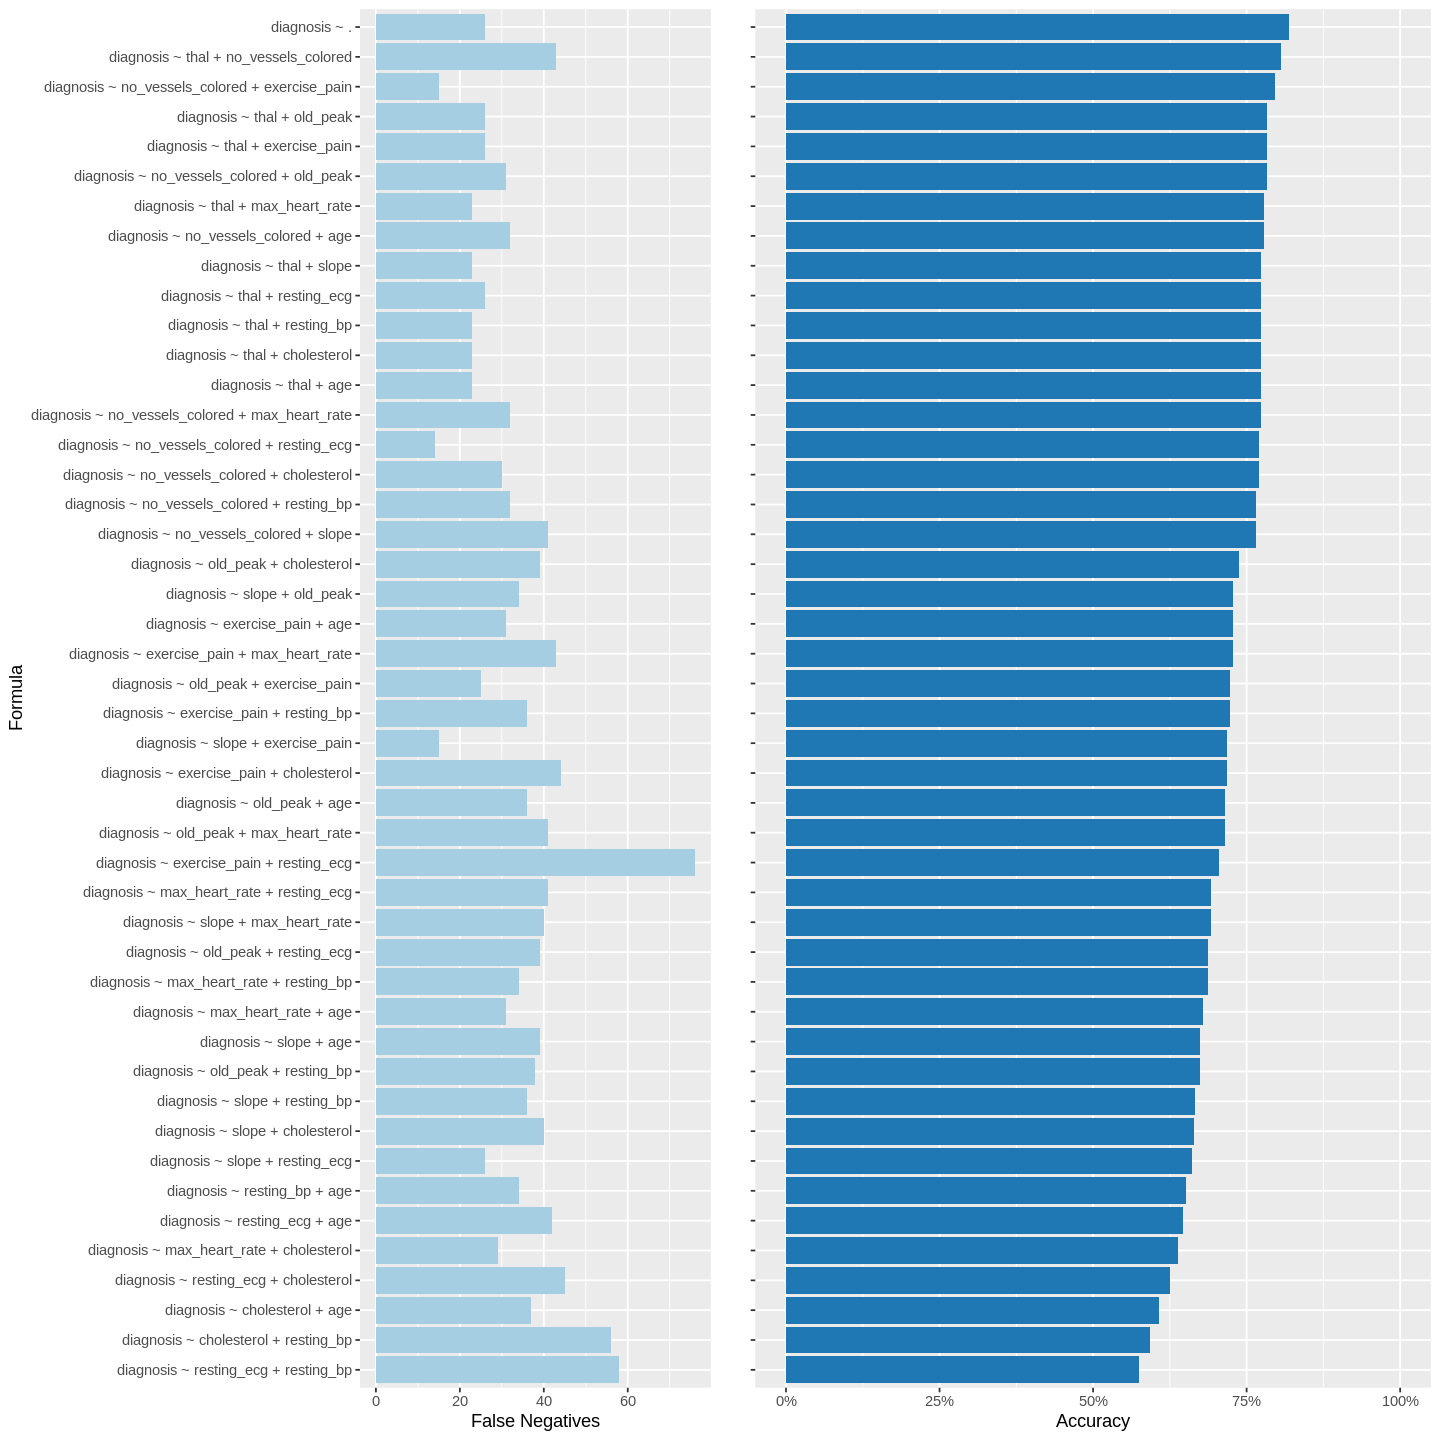

In [16]:
plot_acc <- two_predictors %>% ggplot(aes(x=accuracy, y=reorder(formula, accuracy))) + geom_bar(stat="identity", fill="#1f78b4") +
    scale_x_continuous(labels = scales::percent, limits=c(0,1)) + xlab("Accuracy") + ylab("") + 
    theme(axis.text.y=element_blank()) 
plot_false <- two_predictors %>% ggplot(aes(x=false_healthy, y=reorder(formula, accuracy))) + geom_bar(stat="identity", fill="#a6cee3") +
    xlab("False Negatives") + ylab("Formula")

options(repr.plot.width = 12, repr.plot.height = 12) 
plot_grid(plot_false, plot_acc, ncol = 2)

<span style="color: gray;">Figure 3. The (a) False Negatives value and (b) Accuracy percentage of different combinations of predictors</span>

### Model Selection & Verification

We now have to select the formula we want to use.

For this, we mostly want high accuracy. If the accuracy is comparable, we want to make sure to choose the one with fewer false negatives. As we are aiming for a simple check-up, using all predictors (`diagnosis ~ .`) is not ideal, though yielding the highest accuracy. We pick `no_vessels_colored + exercise_pain`, because it has very few false negatives and almost the same accuracy as the best formula.

In [17]:
two_predictors %>% filter(formula == "diagnosis ~ ." | 
                          formula == "diagnosis ~ no_vessels_colored + exercise_pain")

formula,k,accuracy,false_healthy
<chr>,<dbl>,<dbl>,<int>
diagnosis ~ .,25,0.8185483,26
diagnosis ~ no_vessels_colored + exercise_pain,11,0.7964318,15


<span style="color: gray;">Table 8. The accuracy results for the selected formula, compared with the "all predictors" version</span>

The chosen model uses the number of vessels colored and exercise pain as predictors.
The number of vessels colored is measured by a procedure called fluoroscopy, in which a colored dye is injected to color the blood vessels. The vessels are subsequently imaged by passing x-rays through the body and the blood flow can be monitored over a period of time (6). The higher accuracy of using this predictor is logical, as the procedure is a more in depth investigation of the body’s blood flow.
Exercise pain can be evaluated by the patient doing exercises suggested by the doctor and recording any pain that has emerged. Furthermore, there is a very useful tool that doctors use called the exercise electrocardiogram. This can be done to determine the stress on the heart caused by exercising (12).

We can now verify the model on the testing data.

In [18]:
clev_numeric <- transform_numeric(cleveland)

Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(replace(thal, thal == "fix", "5"))`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [19]:
image_recipe <- recipe(diagnosis ~ no_vessels_colored + exercise_pain, data = training_set) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
       set_engine("kknn") %>%
       set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(image_recipe) %>%
       add_model(knn_spec) %>%
       fit(data=training_set)

In [20]:
predictions <- predict(knn_fit , testing_set) %>%
    bind_cols(testing_set)
final_quality <- predictions %>% 
    metrics(truth = diagnosis, estimate = .pred_class) %>% 
    filter(.metric=="accuracy")
predictions %>% conf_mat(truth = diagnosis, estimate = .pred_class)
final_quality

          Truth
Prediction healthy sick
   healthy      24    4
   sick         17   30

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.72


<span style="color: gray;">Table 9. The accuracy results and confusion matrix for <tt>diagnosis ~ no_vessels_colored + exercise_pain</tt></span>

Overall, the accuracy is 72%. This is much lower than on the training set, which can happen, depending on our random split.

Using this version, the rate for diagnosing sick patients as healthy is ~11%. Although this rate is low, it may not be good enough as almost one in nine sick patients are misdiagnosed. However, as this is a simple method for doctors to use as a signal to further monitor patients for risk of developing disease, the accuracy for this version may be acceptable. 

We can also plot the whole data set and the areas where new data points will be classified as sick or healthy (Figure 4).

Warning message:
“Removed 5 rows containing missing values (geom_point).”


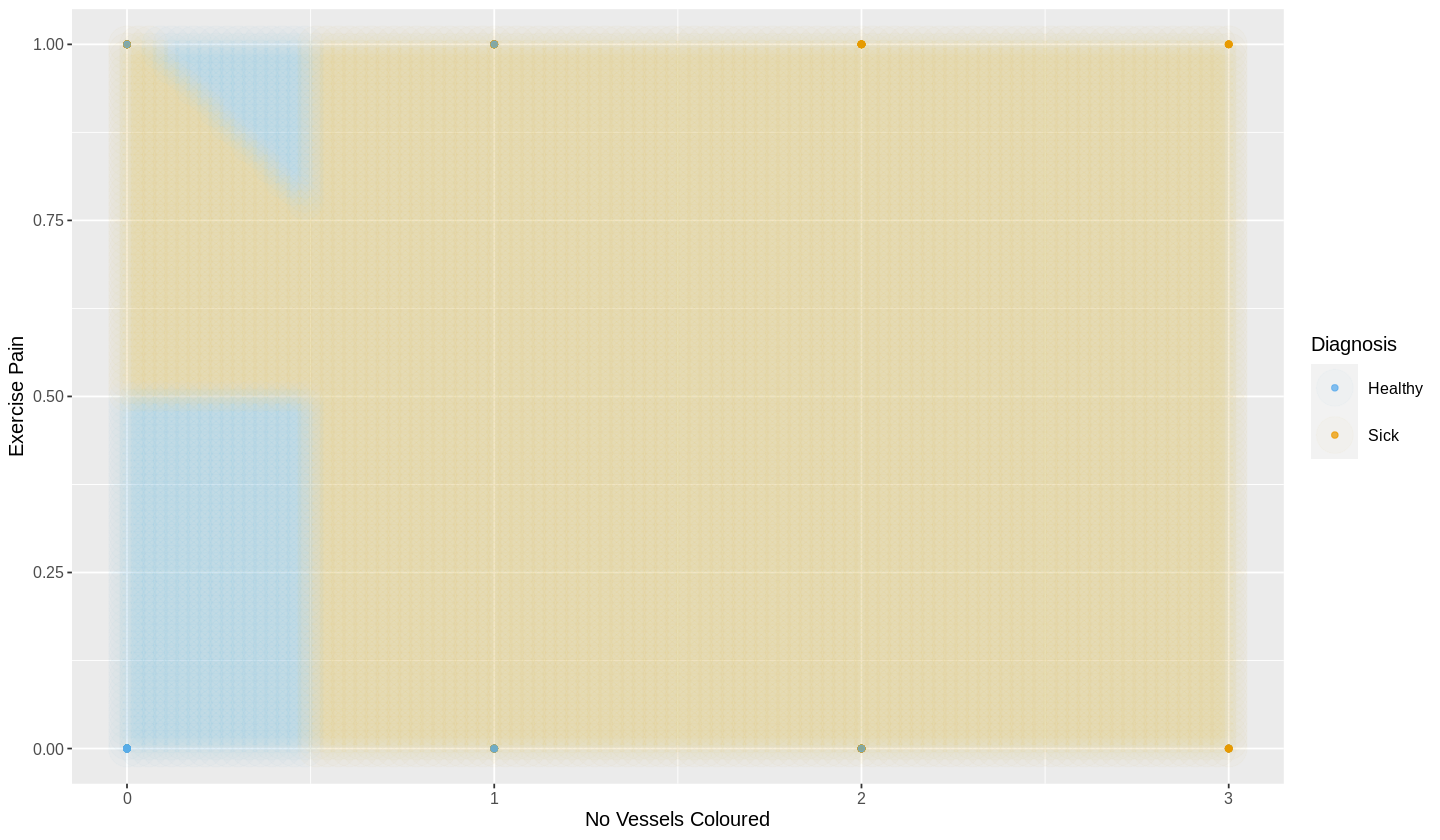

In [21]:
options(repr.plot.width = 12, repr.plot.height = 7) 

# create the grid of area/smoothness vals, and arrange in a data frame
# Code taken and adapted from https://datasciencebook.ca/classification.html#fig:05-upsample-plot
x_grid <- seq(min(clev_numeric$no_vessels_colored, na.rm=TRUE), 
                max(clev_numeric$no_vessels_colored, na.rm=TRUE), 
                length.out = 100)
y_grid <- seq(min(clev_numeric$exercise_pain), 
                max(clev_numeric$exercise_pain), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(no_vessels_colored = x_grid, 
                                exercise_pain = y_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = clev_numeric, 
             mapping = aes(x = no_vessels_colored, 
                           y = exercise_pain, 
                           color = diagnosis), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = no_vessels_colored, 
                           y = exercise_pain, 
                           color = Class), 
             alpha = 0.02, 
             size = 10) +
  labs(color = "Diagnosis", 
       x = "No Vessels Coloured", 
       y = "Exercise Pain") +
  scale_color_manual(labels = c("Healthy", "Sick"), 
                     values = c("steelblue2", "orange2")) +
  theme(text = element_text(size = 12))

wkflw_plot

<span style="color: gray;">Figure 4. Fitting of data with exercise pain and number of colored vessels as predictors</span>

Most of Figure 4 is colored orange, where the diagnosis is sick. This suggests that if there is exercise pain and any number of vessels colored, the diagnosis for a new observation would be classified as sick. There is a spike at the top left corner of the graph which seems a bit strange. This could be due to the neighbor selection of the KNN algorithm: The sick data points at this part could be further away from the new observation, which causes that specific area to be diagnosed as healthy. Note that there will actually never be data within this area, as both axes have factorial values (e.g., you can not have 0.75 exercise pain or 1.3 colored vessels).

## Discussion

This analysis challenges some of the initial research done for this project.  For example, cholesterol is typically considered highly correlated with heart disease (2), however it appears not to be a strong predictor in this data set (Figure 3); there is not a significant distribution difference between the sick and healthy population (Figure 2a). On the other hand, exercise pain is a pretty good predictor for heart disease in this data set, which makes sense from a naive standpoint, as well as from the distribution of the data set (cf. Figure 1).
Beginning this project, we were optimistic about finding a model with high accuracy that could be used to predict heart disease. However, the highest accuracy found during this analysis was just under 82%. Ideally, this analysis would have revealed a set of predictors with an even higher accuracy.

Our model offers a preliminary diagnosis. This can save medical costs for patients who are properly diagnosed with heart disease by our model as well as diagnostic time. Doctors will consider further testing and alert the patient to the possibility of developing heart disease. 
However, it should be noted that despite picking only two predictors, this first check-up is not inexpensive. The testing to obtain the number of vessels colored is more challenging and costly; radioactive dye is required and these tests require very expensive equipment (7). Furthermore, there are health risks associated with this method itself. 

There are several open questions: Can our model be improved to diagnose the severity of heart disease in patients? Are we able to improve our accuracy and false negative rate by taking more predictors? Are there predictors that are less expensive but still achieve a similar accuracy? In our data set, most formulas with high accuracy involve expensive tests (cf. Figure 3). Lastly, is there a more effective and convenient predictor for diagnosing heart disease than the ones used in this analysis? One example for this might be a family history of heart diseases (10).

## References


1. https://www.cdc.gov/heartdisease/facts.htm
2. https://jamanetwork.com/journals/jama/fullarticle/2778234#:~:text=Gary%20Joseph%20Ordog%2C%20MD.&text=Twice%20as%20many%20people%20died,risk%20factors%20as%20heart%20disease.
3. https://pubmed.ncbi.nlm.nih.gov/32219363/
4. https://archive.ics.uci.edu/ml/datasets/Heart+Disease
5. https://datasciencebook.ca/classification.html#classification-with-k-nearest-neighbors
6. https://www.cdc.gov/nceh/radiation/fluoroscopy.html
7. https://health.costhelper.com/stress-tests.html
8. https://datasciencebook.ca/classification2.html#tuning-the-classifier
9. https://datasciencebook.ca/classification2.html#underoverfitting
10. https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease/family-history-and-heart-disease-stroke
11. https://www.google.com/search?q=types+of+angina&oq=types+of+angina&aqs=chrome.0.69i59j0i512l5j0i20i263i512j0i512l3.1938j0j9&sourceid=chrome&ie=UTF-8
12. https://www.heartandstroke.ca/heart-disease/tests/exercise-electrocardiogram